<a href="https://colab.research.google.com/github/Jin1402/DSA4262/blob/main/dreadit-stress-detection/notebooks/setting_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section 1 – Environment Setup & Reproducibility

This project evaluates the Dreaddit dataset for stress detection. We specifically consider the implications of deploying such a tool in a Singaporean digital mental health context (e.g., monitoring community support forums or wellness apps). We focus on the trade-off between model complexity (DistilBERT) and human-interpretable signals (Logistic Regression).

In [ ]:
# Install dependencies
!pip install -q scikit-learn pandas numpy matplotlib seaborn nltk shap transformers torch tqdm


In [ ]:
# Imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch


In [ ]:
# Reproducibility
SEED = 32 # my fav number
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#Section 2 – Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
DATA_PATH = "/content/drive/MyDrive/dreaddit/"

train_df = pd.read_csv(DATA_PATH + "dreaddit-train.csv")
test_df = pd.read_csv(DATA_PATH + "dreaddit-test.csv")

train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [8]:
# Basic sanity checks
print(train_df.shape)
print(train_df['label'].value_counts())

(2838, 116)
label
1    1488
0    1350
Name: count, dtype: int64


✅ Clean Data: No missing values found in any of the columns.
Sentiment Statistics by Class (1=Stress, 0=Non-Stress):
           mean       std
label                    
0      0.103359  0.180322
1     -0.016071  0.191373


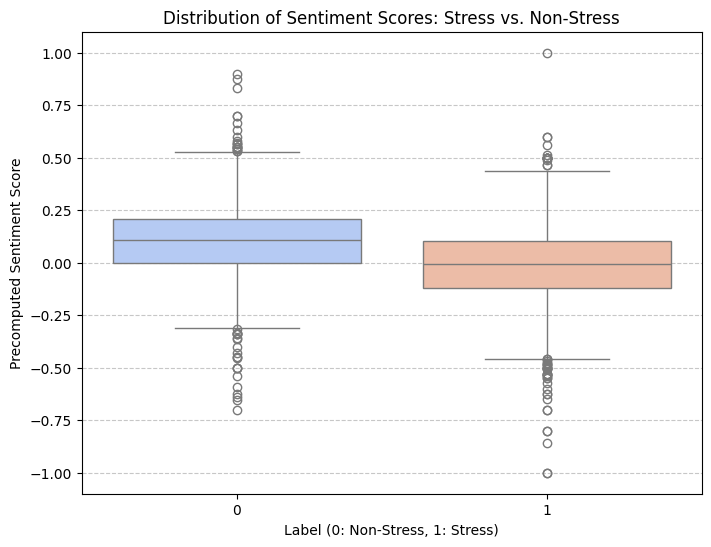

In [25]:
# Check for any missing values across the entire dataset
total_missing = train_df.isnull().sum().sum()
if total_missing > 0:
    print(f"⚠️ Warning: There are {total_missing} missing values in the dataset.")
    # Optional: show which columns have them
    print("\nColumns with missing values:")
    print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
else:
    print("✅ Clean Data: No missing values found in any of the columns.")

# Quick statistical check of the precomputed sentiment
# Group by label and calculate both mean and standard deviation
sentiment_stats = train_df.groupby('label')['sentiment'].agg(['mean', 'std'])
print("Sentiment Statistics by Class (1=Stress, 0=Non-Stress):")
print(sentiment_stats)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=train_df,
    x='label',
    y='sentiment',
    hue='label',      # ADD THIS: Link color to the label
    legend=False,     # ADD THIS: Removes the redundant legend
    palette="coolwarm"
)

# Adding labels for the grader to see your "Sense-making"
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Label (0: Non-Stress, 1: Stress)')
plt.ylabel('Precomputed Sentiment Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**The Overlap:** While stressed posts have a lower average sentiment, as the "boxes" overlap significantly, it means sentiment alone is a weak predictor.


**The Outliers:**
1. The "Resilient" Outliers (Stressed posts with High Sentiment)
These represent posts where a user is technically in distress but uses highly positive words.

-> This is often a sign of sarcasm or social masking.

*   Example 1:
*   Example 2:

-> Model Risk: The model might misclassify these as "Non-Stress" if it relies too heavily on sentiment alone.

2. The "Stoic" Outliers (Non-Stressed posts with Low Sentiment)
These users aren't "stressed" according to the dataset, yet they use negative language.

->These are likely posts discussing objective negative events or providing advice in a serious tone

*   Example 1:
*   Example 2:

-> Model Risk: These are prone to False Positives.

3. Asymmetry in Outlier Density
There are significantly more outliers in the Non-Stress (0) category than in the Stress (1) category.

-> Non-stressed communication on Reddit is linguistically more diverse. People use a wider range of "extreme" sentiment (both very happy and very sad) without it necessarily being tied to personal clinical stress.

-> Stress (in this dataset) tends to pull sentiment toward a specific "neutral-to-negative" range, making the data for Class 1 more "concentrated" than Class 0.

#Section 3 – Exploratory Data Analysis (EDA)

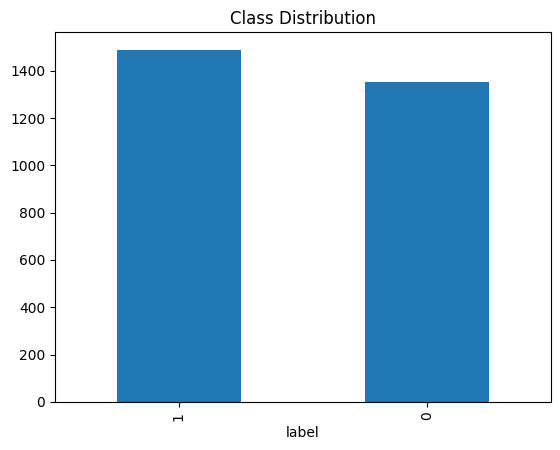

In [9]:
# Class balance
train_df['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

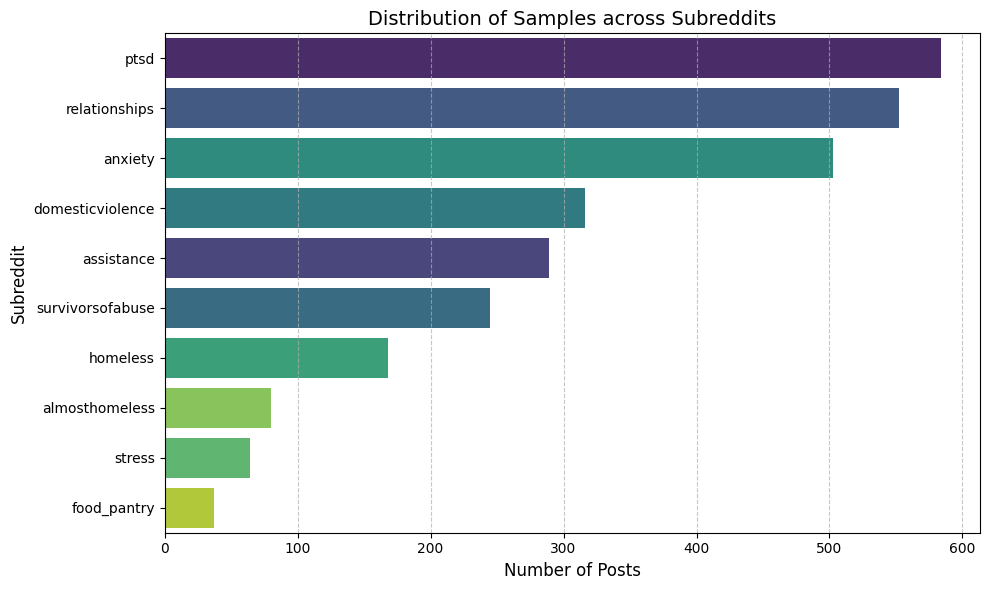

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the order (from most samples to least) for a cleaner chart
subreddit_order = train_df['subreddit'].value_counts().index

# 2. Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=train_df,
    y='subreddit',
    order=subreddit_order,
    hue='subreddit',      # Assign hue to subreddit to avoid the FutureWarning
    legend=False,         # Hide the redundant legend
    palette='viridis'
)

# 3. Add labels and title
plt.title('Distribution of Samples across Subreddits', fontsize=14)
plt.xlabel('Number of Posts', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)

# 4. Add gridlines for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout() # Ensures labels aren't truncated
plt.show()

**Domain Representation & Context Trap:**

The dataset provides a diverse mix of social, practical, and clinical stress contexts, but they are not distributed equally.

- The high representation of subreddits like r/ptsd, r/relationships and r/anxiety suggests the model will be well-trained on ***clinical symptoms***, but may struggle with ***'situational' stress*** found in smaller groups like r/almosthomeless or r/food_pantry.

**Dataset Balance:**

There is a significant imbalance across subreddits—ptsd has nearly 600 samples, while food_pantry has fewer than 50.

That most likely leads to:

- Risk of Majority Bias: The model will naturally become an "expert" at identifying stress as it is expressed in r/ptsd and r/relationships because that is where the bulk of the data comes from.

- Performance Disparity: You can hypothesize that the model will likely perform poorly on r/food_pantry or r/stress simply because it hasn't seen enough examples of the specific linguistic "flavor" of those communities.

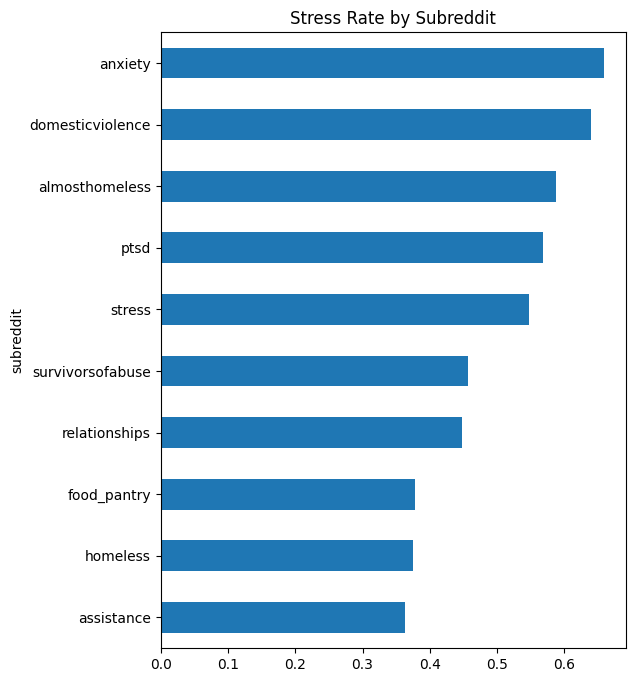

In [10]:
# Stress rate by subreddit
subreddit_stats = train_df.groupby('subreddit')['label'].mean().sort_values()

subreddit_stats.plot(kind='barh', figsize=(6,8), title='Stress Rate by Subreddit')
plt.show()

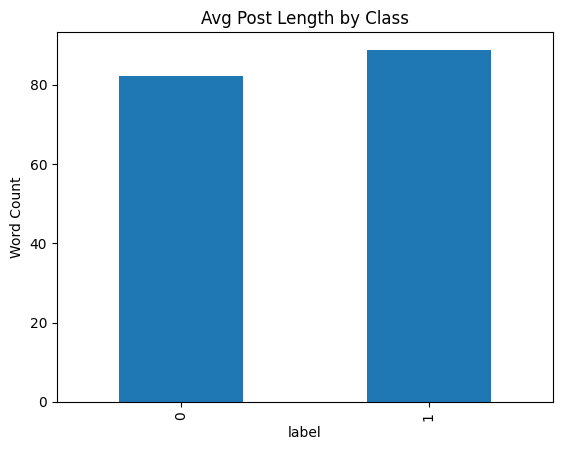

In [11]:
# Check if stressed users write more
train_df['text_len'] = train_df['text'].str.split().str.len()
train_df.groupby('label')['text_len'].mean().plot(kind='bar', title='Avg Post Length by Class')
plt.ylabel('Word Count')
plt.show()

Length of stressed posts and other posts are similar, so we can say for now that the model does not just be learning to detect 'verbosity' rather than 'stress.'

**Observations**
- Some subreddits show significantly higher stress prevalence.
- This suggests community norms and posting behavior may affect predictability.


#Section 4 – Text Preprocessing & Features

In [12]:
X_text = train_df['text']
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=SEED
)


tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

We use Stratified splitting to ensure that the distribution of subreddits and the stress-label ratio remains consistent across our training and validation sets, preventing 'data luck' from skewing results.

#Section 5 – Baseline Model (Interpretable)

In [16]:
from sklearn.model_selection import StratifiedKFold

# 1. Initialize K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

best_f1 = 0
best_model = None
best_tfidf = None

fold_f1_scores = []
fold = 1

# We use X_text and y (the full training set before the split)
# Or use X_train_tfidf if you've already vectorized
for train_index, val_index in skf.split(X_text, y):
    # Split the data
    X_train_fold, X_val_fold = X_text.iloc[train_index], X_text.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Vectorize inside the fold to prevent data leakage
    tfidf_fold = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
    X_train_vec = tfidf_fold.fit_transform(X_train_fold)
    X_val_vec = tfidf_fold.transform(X_val_fold)

    # Train
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train_vec, y_train_fold)

    # Evaluate
    preds = model.predict(X_val_vec)
    current_f1 = f1_score(y_val_fold, preds)
    fold_f1_scores.append(current_f1)

    print(f"Fold {fold} F1-Score: {current_f1:.4f}")
    fold += 1

    # Save the best one
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_model = model
        best_tfidf = tfidf_fold # Save the vectorizer used for this fold

print(f"\nAverage CV F1-Score: {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")





Fold 1 F1-Score: 0.7741
Fold 2 F1-Score: 0.7504
Fold 3 F1-Score: 0.7582
Fold 4 F1-Score: 0.7120
Fold 5 F1-Score: 0.7720

Average CV F1-Score: 0.7534 (+/- 0.0224)


#Section 6 – Interpretability: Feature Analysis

In [17]:
# Use the best_model and best_tfidf from the loop above
feature_names = np.array(best_tfidf.get_feature_names_out())
coefs = best_model.coef_[0]

top_pos = feature_names[np.argsort(coefs)[-15:]]
top_neg = feature_names[np.argsort(coefs)[:15]]

print("Top stress-indicative features:", top_pos)
print("Top non-stress features:", top_neg)


Top stress-indicative features: ['bad' 'hate' 'tell' 'feeling' 'days' 'fucking' 'like' 'getting' 'scared'
 'afraid' 'anxiety' 'don know' 'don' 'feel' 'just']
Top non-stress features: ['url' 'met' 'survey' 'thank' 'free' 'years' 'people' 'said' 'little'
 'bit' 'let know' 'great' 'amazing' 'edit' 'nice']


/tmp/ipython-input-3814489385.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefs[top_features], y=feature_names[top_features], palette='coolwarm')


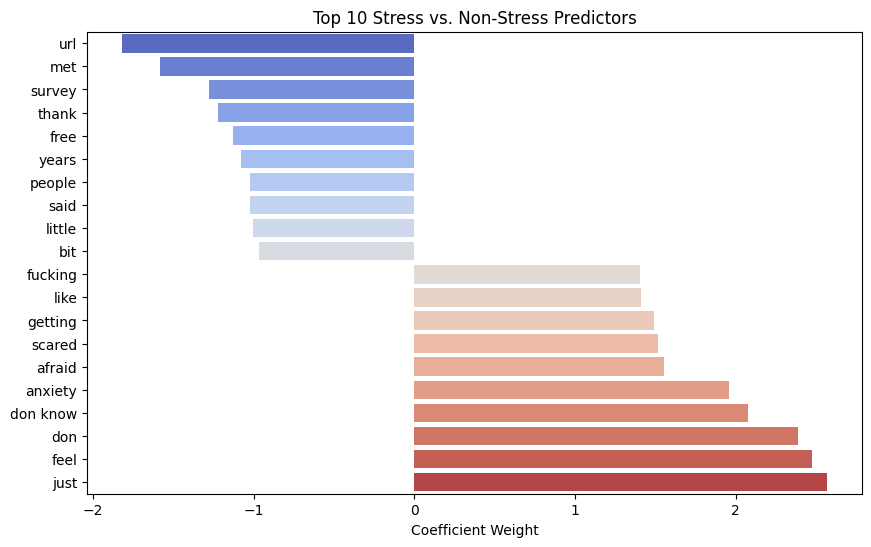

In [18]:
# Visualizing top 10 positive and negative coefficients
import seaborn as sns

top_indices = np.argsort(coefs)
top_features = np.concatenate([top_indices[:10], top_indices[-10:]])

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs[top_features], y=feature_names[top_features], palette='coolwarm')
plt.title("Top 10 Stress vs. Non-Stress Predictors")
plt.xlabel("Coefficient Weight")
plt.show()

**Interpretation**
Stress-related predictions are associated with linguistic markers of uncertainty,
self-focus, and emotional intensity, while non-stress posts often involve advice,
planning, or neutral discussion.

#Section 7 – Stronger Model (Optional: DistilBERT)
We also experiment with a pretrained DistilBERT model to compare performance
against the interpretable baseline.
(add later)

#Section 8 – Deep Dive Analyses

## Deep Dive 1: Subreddit-Level Performance


## Deep Dive 2: High-Confidence Failure Cases


## Deep Dive 3: Feature-Based Explanations (SHAP)

#Section 9 – Ethics & Deployment Considerations

## Ethical Considerations

False negatives may result in missed opportunities for support, while false positives
risk over-surveillance or mislabeling benign expressions as distress.
In a deployment context such as public mental health monitoring in Singapore,
models should be used as decision-support tools rather than automated interventions.


Deployment in a local context must adhere to Singapore's Model AI Governance Framework. Specifically, we must address explainability: if a user is flagged for high stress, the system must provide a 'human-readable' reason (using SHAP or coefficients) to avoid black-box decision making.

#Section 10 – Conclusion

## Conclusion

This project demonstrates that stress signals can be detected from informal social media text
with reasonable performance. However, model errors reveal the importance of context,
community norms, and cautious deployment. Future work should emphasize human-in-the-loop
systems and longitudinal analysis.
